# Comparing contextual vectors

In [ ]:
!pip install torch transformers datasets bertviz seaborn scikit-learn

In [2]:
import numpy as np
import datasets
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from bertviz import model_view, head_view

So far, we have been working with *static* word (or sequence) embeddings.   
Word2vec is an example of static word embeddings – it has a set vocabulary, where each word has a single embedding that is the same no matter the case.

But as we know, words can take on different meanings depending on their context. 
Contextualized embeddings aim to learn something about the semantics of the whole sequence. Practically, contextualized embeddings, like those produced by Transformer models, generate different embeddings for the same word based on its surrounding context. 

It should be possible to capture the difference between "bank" in "river bank" vs. "bank loan". 

One of the mechanisms that allows this is attention.
Let's start seeing if we can recreate the example from lecture: `"The cat sat on the mat"` with a real model.

In [3]:
sentence = "The cat sat on the mat"

In [4]:
# Load a small pretrained transformer model to extract embeddings and attention
model_name = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name, output_attentions=True, attn_implementation="eager")

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [5]:
# Tokenize
inputs = tokenizer(sentence, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1996,  4937,  2938,  2006,  1996, 13523,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
# Run inference
with torch.no_grad():
    outputs = model(**inputs)

In [28]:
# Extract embeddings (last hidden state) and attention from the model
embeddings = outputs.last_hidden_state  
attentions = outputs.attentions  

# Decode tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

In [8]:
# embeddings are a tensor shape (batch_size, sequence_length, embedding_size)
embeddings.shape

torch.Size([1, 8, 512])

In [9]:
# attentions is a tuple of tenros...
[
    type(attentions),
    len(attentions)
]


[tuple, 4]

In [10]:
# ...where each layer has (batch_size, num_heads, sequence_length, sequence_length)
attentions[0].shape

torch.Size([1, 8, 8, 8])

Let's see how that looks visualized.

This specific model has just 4 layers of attention (this is actually quite low). 
 
And 8 attention heads. This number has nothing to do with the specific sentence (which is 8 tokens long), but instead, this is decided by the model's architecture.

In [11]:
head_view(attentions, tokens)

<IPython.core.display.Javascript object>

Or you can plot each attention head separately:

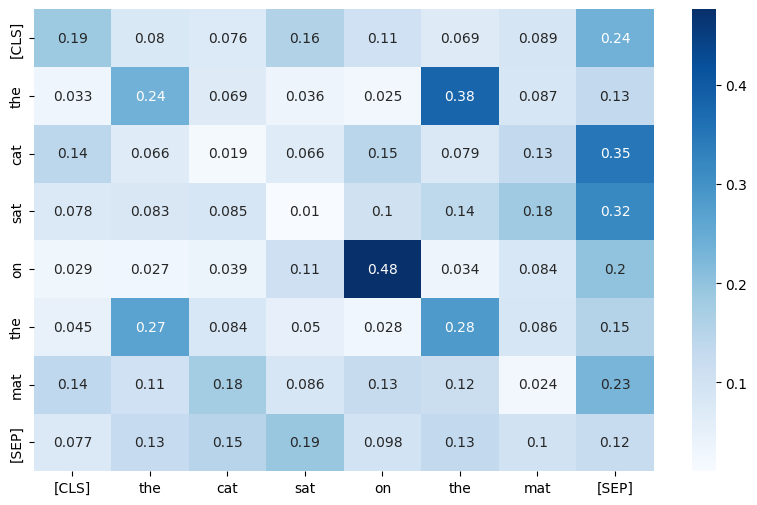

In [12]:
# Attention from the first layer, first head
L1H1 = attentions[0][0, 0]

# Plot attention weights for the CLS token (attention_scores[0] gives weights from CLS to all tokens)
plt.figure(figsize=(10, 6))
sns.heatmap(L1H1, annot=True, xticklabels=tokens, yticklabels=tokens, cmap='Blues')
plt.show()

In [13]:
# plot all attention heads in the model
model_view(attentions, tokens)

<IPython.core.display.Javascript object>

Relevant at this point (but will be on the readings later):

- [CLS] is a special token added at the beginning of each sequence. It means “classification” and should contain some information representing the whole sequence.
- [SEP] is a special token used to separate two sequences in tasks like question answering or sentence pair classification. It also marks the end of a single sequence when only one is provided.

These special tokens are specific to the BERT architecture (Devlin et al., 2019)

Now, what do there connection mean?

1. which attention heads are covering the words that attend to themselves?
2. which heads are capturing the order of words in the sentence?
3. which heads are telling the [CLS] token what is important in the sentence?

### Comparing embeddings – Projections
Let's try to project the embeddings using dimensionality reduction to get more insight into how meaning is represented in our model.  


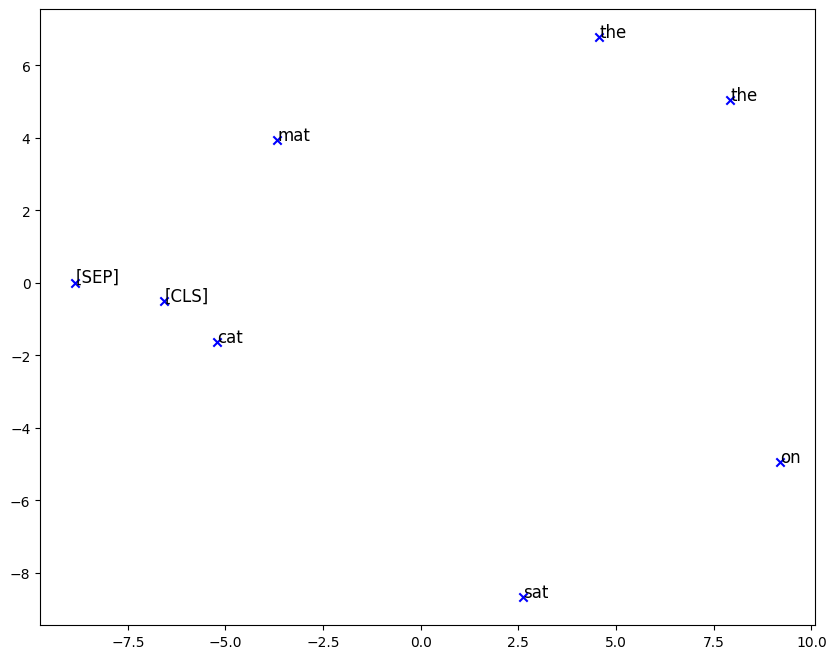

In [14]:
embeddings = embeddings.squeeze(0)  # Remove the batch dimension

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Plot the 2D projection of BERT embeddings
plt.figure(figsize=(10, 8))
for i, token in enumerate(tokens):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='x', color='blue')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], token, fontsize=12)


Notice where the embeddings landed.
What is happening here?

What characteristic do the outlier words share?  
What kind of words are close to the [CLS], central token?

### Paraphrasing – distance between sentences

The goal of the model is to embed similar sentences close to each other in the embedding space. 
A nice case for this is paraphrasing – saying (almost) the same thing using different words. 
If a model is able to detect paraphrases, this is a good indication of its performance.

So, our goal is to test whether the model understands that 
`"In 1995, the last survey, those numbers were equal."` is equivalent to `"The last time the survey was conducted, in 1995, those numbers matched."`

To do that, we will measure distance between embeddings of the two sentences.
We have to implement a distance metric first.

In [20]:
A = torch.Tensor([0.5, 0.2, 0.7])
B = torch.Tensor([0.2, 0.1, 0.5])

dot_product = torch.dot(A,B)
norm_A = torch.norm(A)
norm_B = torch.norm(B)
resultat = dot_product/(norm_A*norm_B)
resultat

tensor(0.9716)

In [76]:
# Implement a cosine similarity in any way
def cosine_similarity(A, B) -> float:
    """
    Dot product of two vectors divided by the product of their norms (magnitudes)
    
    """
    dot_product = torch.dot(A,B)
    norm_A = torch.norm(A)
    norm_B = torch.norm(B)
    resultat = dot_product/(norm_A*norm_B)

    return(resultat)

# test if it works
testing_results = cosine_similarity(
    A = torch.Tensor([0.5, 0.2, 0.7]),
    B = torch.Tensor([0.2, 0.1, 0.5])
    )

assert np.isclose(testing_results, 0.9716)

In [78]:
# Implement a function for extracting embeddings
def infer_embedding(sentence: str) -> torch.Tensor:
    """
    """
    # TODO tokenize (with a tokenizer)
    inputs = tokenizer(sentence, return_tensors='pt', padding = True)

    # TODO inference (torch.no_grad)
    with torch.no_grad():
        outputs = model(**inputs)

    # TODO squeeze last hidden state and return it
    # Extract embeddings (last hidden state) and attention from the model
    embeddings = outputs.last_hidden_state  
    squeezed_embeddings = torch.squeeze(embeddings, 0)
   
    return(squeezed_embeddings)

assert infer_embedding("test test test").shape == (5, 512)

In [125]:
original_sent = "In 1995, the last survey, those numbers were equal."
paraphrased_sent = "The last time the survey was conducted, in 1995, those numbers matched."

In [126]:
# run the little test

emb_orig_sent = infer_embedding(original_sent)
emb_para_sent = infer_embedding(paraphrased_sent)

cls_orig_sent = emb_orig_sent[0, :]
cls_para_sent = emb_para_sent[0, :]

mean_orig_sent = torch.mean(emb_orig_sent, dim=0) # has to be dim 0, because we want the average activation per word
mean_para_sent = torch.mean(emb_para_sent, dim=0)

max_orig_sent = torch.max(emb_orig_sent, dim=0)[0] # the second [0] takes the values and not the indices
max_para_sent = torch.max(emb_para_sent, dim=0)[0]

print(f"Cosine similarity (CLS token): {cosine_similarity(cls_orig_sent, cls_para_sent)}")
print(f"Cosine similarity (Mean pooling): {cosine_similarity(mean_orig_sent, mean_para_sent)}")
print(f"Cosine similarity (Max): {cosine_similarity(max_orig_sent, max_para_sent)}")

Cosine similarity (CLS token): 0.8661871552467346
Cosine similarity (Mean pooling): 0.8752886652946472
Cosine similarity (Max): 0.9387845993041992


Thoughts?  
Do the similarities indicate that the sentences are paraphrased?  

Let's see how representative the different measures are in a projection:

In [127]:
pca = PCA(n_components=2)
emb_orig_2d = pca.fit_transform(emb_orig_sent)
emb_para_2d = pca.transform(emb_para_sent)
cls_orig_2d = pca.transform(cls_orig_sent)
cls_para_2d = pca.transform(cls_para_sent)


plt.figure(figsize=(10, 8))
for i, token in enumerate(tokens):
    plt.scatter(emb_orig_2d[i, 0], emb_orig_2d[i, 1], marker='x', color='blue')
    plt.scatter(emb_para_2d[i, 0], emb_para_2d[i, 1], marker='x', color='blue')
    plt.scatter(cls_orig_2d[i, 0], cls_orig_2d[i, 1], marker='x', color='red')
    plt.scatter(cls_para_2d[i, 0], cls_para_2d[i, 1], marker='x', color='red')

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.69728011e-01  1.34435371e-01  4.05786872e-01 -9.05322194e-01
 -3.63821894e-01 -1.31789863e-01 -5.58004797e-01 -6.39327168e-02
 -1.21476531e+00  1.26290810e+00 -1.50354218e+00 -3.57427895e-02
  5.35422087e-01 -1.18768406e+00  8.59165728e-01  3.97955626e-01
  1.09797931e+00  1.87919855e-01  1.13266420e+00  1.74052328e-01
 -9.59557474e-01  2.97035962e-01  2.08339617e-01  6.02539003e-01
  5.57833552e-01 -5.66028953e-01 -9.58719790e-01 -8.25532153e-02
  3.61107528e-01 -7.45211959e-01 -6.04736984e-01 -1.68065682e-01
 -9.81481850e-01  1.72707886e-01  5.23328364e-01  1.07361627e+00
  2.02259257e-01  2.38869831e-01 -2.47066081e-01  2.71581858e-01
 -4.08502162e-01 -4.18535948e-01 -3.79945338e-02  3.10504347e-01
 -2.35299617e-01  5.66094041e-01  8.82426679e-01 -9.62718651e-02
  1.67631999e-01  1.82238281e+00 -9.04209390e-02  1.50669765e+00
 -1.43260658e-01  5.78993380e-01 -7.25730360e-01 -3.59191775e-01
  1.99727714e-01 -3.01683605e-01  9.62824166e-01 -6.00790501e-01
 -2.26625338e-01 -8.86303246e-01  1.19078469e+00  4.67780530e-01
  5.88791013e-01 -1.36928988e+00 -7.95172870e-01  7.61700511e-01
 -4.41351920e-01  8.97212923e-01 -4.19967800e-01  2.29698405e-01
  4.99848604e-01  8.81284103e-02 -5.45360781e-02 -7.00982511e-01
  5.77785671e-01 -2.49637604e-01  2.95097709e-01 -1.05603591e-01
  5.45397103e-01  4.92339581e-01  6.19944990e-01  8.29756677e-01
 -1.16345906e+00 -9.64332223e-01 -1.75652429e-01  2.47157756e-02
  3.37293267e-01  7.57677779e-02 -1.05147433e+00 -3.23874682e-01
 -2.93636739e-01 -9.20107484e-01 -1.91614783e+00 -5.79898834e-01
 -7.97093809e-01  1.03417933e+00  3.70047577e-02  4.94516730e-01
 -4.06161278e-01  1.93138257e-01  8.00547540e-01  5.41076720e-01
  1.30100286e+00 -1.51694775e+00  5.42507052e-01 -2.32326999e-01
 -6.16269886e-01 -1.70486853e-01  3.80412899e-02  2.53685981e-01
 -2.42610008e-01 -2.69636303e-01  3.79096240e-01 -2.93744177e-01
 -2.02841148e-01 -6.52142704e-01  3.19689125e-01  1.06437111e+00
  2.28805810e-01  3.06401223e-01 -1.13691854e+00  5.95888674e-01
 -6.83434546e-01 -6.94417357e-01 -5.61101781e-03  8.89641568e-02
  5.32971621e-01 -4.65962410e-01 -3.06419015e-01 -7.39932284e-02
  7.58392513e-02  7.06491292e-01 -2.91572630e-01  7.38127947e-01
 -1.46182191e+00  1.49324453e+00  1.54422775e-01  2.51643956e-01
  2.51759067e-02  9.87989008e-01 -6.96680188e-01  1.50095955e-01
 -1.70236856e-01  4.38646197e-01 -4.03797746e-01  2.64156461e-01
  1.25442767e+00 -2.38394275e-01 -2.74878561e-01  1.15098000e+00
 -6.97591305e-01  8.02721441e-01  1.98926106e-01  3.80076771e-03
  8.46372724e-01 -7.62513876e-01  9.10118341e-01 -6.64775193e-01
  7.20204771e-01 -6.90653265e-01  1.45423901e+00 -1.84528485e-01
 -3.24384153e-01 -3.95292528e-02  1.04603148e+00 -8.37011516e-01
 -1.06780577e+00 -1.42683172e+00  1.18579435e+00  2.30430794e+00
  2.28785008e-01 -3.39949906e-01 -3.31786811e-01 -1.49026021e-01
  8.54055583e-02  1.04420163e-01 -3.21783692e-01 -6.20226800e-01
  8.56064782e-02 -2.72349659e-02 -4.98797977e-03 -8.40426534e-02
 -8.71526748e-02  1.06425512e+00  8.47226441e-01 -9.66289997e-01
 -1.50215316e+00  1.61043811e+00  3.90734434e-01  7.10889697e-01
 -7.53399134e-01 -3.52139175e-02  3.27145047e-02 -8.41543913e-01
 -1.17492712e+00 -1.02700198e+00 -8.32759559e-01 -1.45445156e+00
 -7.26348281e-01  8.26916099e-01 -7.51775876e-02 -5.13942719e-01
 -8.70512366e-01  4.53029685e-02 -5.19684851e-01 -1.55546159e-01
 -9.91218328e-01 -1.77294631e-02 -6.29374981e-01 -1.75967634e-01
 -4.61138815e-01 -6.91733956e-01  5.06206274e-01  3.36714268e-01
 -1.43675458e+00 -1.36072621e-01  4.55692023e-01 -1.70879495e+00
 -1.17134303e-01  6.96638942e-01  1.00523031e+00 -1.71621174e-01
 -1.42055556e-01 -3.48295063e-01 -3.86590391e-01 -1.55138299e-01
 -1.16027117e+00  9.14541185e-01 -4.75648373e-01 -7.29505122e-01
 -6.70016631e-02  8.60376239e-01  2.82873154e-01 -7.74181306e-01
 -1.29881763e+00  7.02171803e-01  7.39523709e-01  7.79788733e-01
  2.21842289e-01 -1.21510577e+00  1.36126101e-01 -1.60523152e+00
 -5.19933820e-01  8.74482512e-01 -1.08370364e+00 -2.23939195e-01
  5.13083339e-01  4.07373697e-01  7.06970394e-01 -4.09042090e-01
  3.84451181e-01 -7.69383371e-01 -1.06019425e+00  1.57284868e+00
  1.14006150e+00  4.43189651e-01 -9.29111719e-01  5.60859680e-01
 -3.24347734e-01 -2.03780681e-01  9.86729503e-01  2.09956571e-01
 -2.20992103e-01  1.91767111e-01  2.99158245e-01 -2.01427490e-01
 -4.21557009e-01  7.72381544e-01 -8.16150457e-02 -6.53839648e-01
  2.34069914e-01  4.14992064e-01 -5.81139743e-01  3.51146340e-01
 -4.36305809e+00 -1.25214076e+00  9.32196617e-01  1.47520745e+00
 -5.86152732e-01  6.42798841e-02  3.70247185e-01 -4.57068950e-01
  1.32539600e-01  8.63925636e-01 -4.05439407e-01 -5.91926992e-01
  1.22929692e+00  2.64129758e-01  4.73045498e-01  4.17593300e-01
  1.07759213e+00  1.46689606e+00  6.64802253e-01  2.30058338e-02
  9.21974778e-01 -2.16474995e-01  1.21317101e+00  3.26438904e-01
 -8.06950808e-01 -9.26718339e-02 -5.53299010e-01 -4.56464082e-01
 -9.89375710e-02 -2.49420002e-01  3.32882732e-01 -1.48835564e+00
  2.55766958e-01  1.27484238e+00  6.80045724e-01 -3.00869405e-01
 -1.43159437e+00  1.24436580e-01  3.79493535e-01 -1.34044483e-01
 -8.53162706e-01 -4.32009965e-01 -1.02235794e-01  3.29852775e-02
 -2.62623638e-01 -5.05619764e-01 -9.07357275e-01  4.20640856e-01
 -3.15342158e-01  5.69430590e-01 -3.81355345e-01 -7.55501091e-02
 -7.43006587e-01  1.62493706e-01 -9.58828509e-01  3.06166857e-01
  1.52076721e-01 -1.16500616e+00  1.20946705e+00  6.58889711e-01
 -6.72515631e-01  1.66779831e-01 -1.14494555e-01  8.22141349e-01
  6.34494722e-01 -9.12323058e-01  4.39116389e-01 -2.07665890e-01
 -7.22898662e-01  7.61028349e-01 -3.95442843e-01 -1.37400162e+00
  5.32301903e-01  1.30522594e-01 -3.43982816e-01  4.40225661e-01
 -4.44825023e-01 -1.61072448e-01 -5.10873854e-01 -2.75081456e-01
 -1.71773806e-01 -1.97605401e-01 -7.07022548e-01 -8.21075857e-01
  9.49208319e-01 -2.61439651e-01 -9.05893981e-01 -4.33720291e-01
  5.72320402e-01  1.15793014e+00  3.40929590e-02 -2.34864682e-01
 -4.34212774e-01 -4.50046271e-01 -8.67116332e-01  2.97812130e-02
 -5.54416142e-03  5.72080731e-01  4.86051142e-01 -1.27778336e-01
  1.18199334e-01 -4.15101908e-02 -4.58527319e-02 -1.29483521e+00
  3.21457505e-01  3.76668781e-01  3.86613876e-01 -1.31248736e+00
 -1.53063685e-01 -9.82510746e-01 -5.59497893e-01  9.98593330e-01
 -3.35499436e-01  3.34395975e-01  4.40019816e-01  8.47499669e-01
 -1.53101194e+00  6.12879217e-01 -1.06118351e-01 -6.67937934e-01
 -3.34270358e-01  2.13030815e-01 -1.40952003e+00  1.83798358e-01
 -3.56811211e-02 -3.90540510e-01 -3.41822922e-01 -6.18505359e-01
  3.72761101e-01 -8.86637866e-01 -2.72356510e-01 -4.12709981e-01
 -4.62045282e-01  9.53572452e-01 -8.63850713e-01  9.61988047e-02
  8.75899494e-01  5.70828438e-01 -2.67611116e-01 -6.02288432e-02
 -1.74896944e+00  2.47807786e-01  4.38869238e-01  1.13645113e+00
  3.80945534e-01 -3.11826706e-01  8.64942431e-01  2.83764988e-01
  1.18174270e-01  6.66940868e-01 -6.23758018e-01  1.67161453e+00
 -1.18377650e+00  1.71913043e-01 -7.06691146e-01 -8.17183554e-02
  7.76885033e-01 -1.00445531e-01 -1.17433333e+00  5.46655238e-01
  5.86956739e-01  1.69392034e-01 -7.78209388e-01 -1.55247012e-02
 -4.99300957e-01 -2.01254293e-01 -9.78145719e-01 -1.08622909e+00
  2.14853096e+00 -1.97245741e+00 -4.93758249e+00  9.97602284e-01
  3.73108566e-01  4.12582874e-01  1.47811607e-01 -1.58960313e-01
  6.21995747e-01 -5.55466488e-02  4.56910372e-01  1.58294225e+00
 -1.68530583e+00  3.44523966e-01  9.45131838e-01  7.71854818e-01
 -1.62217557e-01  4.53599870e-01 -2.33897179e-01  3.62713623e+00
 -1.29629776e-01  6.22913718e-01 -5.70426524e-01 -5.63143432e-01
 -1.12543893e+00  1.16847003e+00  7.85818636e-01  5.66328347e-01
 -6.27772570e-01 -6.49419010e-01  1.45130530e-01  8.59571323e-02
  7.00851202e-01  1.10591933e-01  4.80658293e-01  1.39084339e-01
 -1.46569073e-01  3.88004035e-01 -5.11520386e-01 -1.14587283e+00
  1.24808937e-01 -5.94627976e-01  9.45089087e-02  1.84274837e-01
  3.55679845e-03  2.10086322e+00  7.17871189e-01  1.69082865e-01
  9.16541815e-01 -1.92012131e-01  4.69112664e-01  7.51972675e-01
  5.01194537e-01 -5.81242442e-02 -3.61514658e-01  1.11892307e+00
 -3.34734172e-01 -7.53978074e-01 -6.52005494e-01 -2.79871196e-01
 -3.85442615e-01 -1.10905603e-01  8.22717130e-01  5.47514975e-01
  1.11756134e+00 -7.47647285e-01  2.93041557e-01  5.51379740e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Bonus: 
- Dependency distance: does it relate to attention, check using `spacy`

### First taste of masked learning

In [ ]:
# masked attention
# 1. Define the sentence
sentence = "The [MASK] sat on the mat"

# 2. Load a pretrained BERT tokenizer and model for embedding generation
model_name = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# 3. Tokenize the sentence
inputs = tokenizer(sentence, return_tensors='pt')

# 4. Generate embeddings and attention weights using BERT
with torch.no_grad():
    outputs = model(**inputs)

# Extract hidden states (embeddings) and attention from the model
hidden_states = outputs.hidden_states  # (layer, batch, seq_len, hidden_size)
attentions = outputs.attentions  # (layer, batch, num_heads, seq_len, seq_len)

# Convert token IDs back to tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

head_view(attentions, tokens)

In [ ]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model=model_name)
unmasker("The [MASK] sat on the mat")

# Building a sentence similarity benchmark

- create a dataset
    - do we need all the datapoints? 
    - the data is scored on an ordinal scale, how do we turn it into a binary problem?
- pick models to compare
- embed the texts
- evaluate accuracy

In [ ]:
# load the datasets
raw_pairs = datasets.load_dataset("mteb/stsb_multi_mt", name="en", split="test")


# create a model registry
model_names = [
    ""
]

In [ ]:
raw_pairs

In [ ]:
# downsample
sample = raw_pairs.train_test_split(train_size=600, stratify_by_column="label", seed=42)

# infer
embeddings = infer_embedding()

Bonus 1:
- find edge cases (instances where the model fails)
- can edge cases be explained with dependency distance?

Bonus 2:
- compare static and contextualized embeddings on the paraphrasing task
- e.g. get representations using GloVe (Class 2, `embeddings = gensim.downloader.load("glove-wiki-gigaword-300")`)